Based on paper: https://doi.org/10.1109/58.710587

In [1]:
# Imports
import numpy as np
from tqdm import tqdm

# Display imports
import matplotlib.pyplot as plt
import imageio
from matplotlib import cm
from matplotlib.colors import Normalize
from IPython.display import Image

In [2]:
# Parameters values

dx = 10 # grid spacing in x
dz = 10 # grid spacing in z
dt = 1e-3 # time spacing
Nt = 1000 # number of time samples
Nx, Nz = 250, 250 # grid size
c0 = 1000.0 # acoustic speed of sound
rho0 = 2200.0 # density
fc = 25.0 # source wave central frenquency
Npml = 20 # PML size
W = 1.0 # normalized maximum PML attenuation coefficient
gain = 1e3 # source gain
gamma_val = 1e-5 # absorption coefficient
a_max = 1.0 # PML real scaling factor

In [3]:
# Fields
vp = np.ones((Nx, Nz), dtype=np.float32) * c0 # acoustic speed
rho = np.ones((Nx, Nz), dtype=np.float32) * rho0 # density

In [4]:
# PML fields
Lpml = Npml * dx
vmax = vp.max()
omega_max = 2*np.pi*fc * W

s = np.arange(0, Npml, dtype=np.float32)
ramp = (s / Npml) ** 2 # Quadratic profile

x_pml = omega_max * ramp
z_pml = omega_max * ramp

omega = np.zeros((2, Nx, Nz), dtype=np.float32) # intrinsic loss in the PML medium
omega[0, :, :Npml]  = np.flip(x_pml)[None, :]
omega[0, :, -Npml:] = x_pml[None, :]
omega[1, :Npml, :]  = np.flip(z_pml)[:, None]
omega[1, -Npml:, :] = z_pml[:, None]

gamma = np.zeros((Nx, Nz), dtype=np.float32) # absorptive loss in the medium

x_profile = np.zeros(Nz, dtype=np.float32)
x_profile[:Npml]  = np.flip(gamma_val * ramp)
x_profile[-Npml:] = gamma_val * ramp

z_profile = np.zeros(Nx, dtype=np.float32)
z_profile[:Npml]  = np.flip(gamma_val * ramp)
z_profile[-Npml:] = gamma_val * ramp

for i in range(Nx):
    for j in range(Nz):
        gamma[i, j] = x_profile[j] + z_profile[i]

a = np.ones((2, Nx, Nz), dtype=np.float32) # real scaling factor
x_pml_a = 1.0 + (a_max - 1.0) * ramp
z_pml_a = 1.0 + (a_max - 1.0) * ramp
a[0, :, :Npml]  = np.flip(x_pml_a)[None, :]
a[0, :, -Npml:] = x_pml_a[None, :]
a[1, :Npml, :]  = np.flip(z_pml_a)[:, None]
a[1, -Npml:, :] = z_pml_a[:, None]

In [5]:
# Ricker source
t0 = 1.0 / fc
t = np.linspace(0, Nt*dt, Nt, dtype=np.float32) - t0
aa = (np.pi * fc * t) ** 2
source = (1 - 2 * aa) * np.exp(-aa)
sx, sz = Nx // 2, Nz // 2 # source position

# "A simple way to eliminate this problem is to approximate the source
# as a spatially smoothed source occupying a volume of only
# a few (four to six) cells in each direction."

smoothed = np.array([
    [0.25, 0.5, 0.25],
    [0.5,  1.0, 0.5],
    [0.25, 0.5, 0.25]
], dtype=np.float32)

In [6]:
# Eq. 16-18
detha = np.array([[[dx]], [[dz]]], dtype=np.float32)

D = a/dt + (a*gamma*vp**2 + omega)/2 + omega*gamma*vp**2*dt/2

g1 = (a/dt - omega/2) / (a/dt + omega/2)
g2 = -1.0 / ((a/dt + omega/2) * rho * detha)
g3 = (a/dt - (a*gamma*vp**2 + omega/2)) / D
g4 = -omega*gamma*vp**2*dt / D
g5 = -rho*vp**2 / D
g6 = 1.0 / D

In [7]:
# Pressure and velocity fields
px = np.zeros((Nx, Nz), dtype=np.float32) # Pressure in x
pz = np.zeros((Nx, Nz), dtype=np.float32) # Pressure in z
p  = np.zeros((Nx, Nz), dtype=np.float32) # Total pressure

pIx = np.zeros((Nx, Nz), dtype=np.float32) # Integrated pressure in x
pIz = np.zeros((Nx, Nz), dtype=np.float32) # Integrated pressure in z

vx = np.zeros((Nx, Nz), dtype=np.float32) # Velocity in x
vz = np.zeros((Nx, Nz), dtype=np.float32) # Velocity in z

In [8]:
# Pseudospectral Operator (Eq. 20-21)
kx = np.fft.fftfreq(Nx, d=dx) * 2.0 * np.pi
kz = np.fft.fftfreq(Nz, d=dz) * 2.0 * np.pi
KX, KZ = np.meshgrid(kx, kz, indexing='ij')

def deriv_fft(x, axis):
    Xf = np.fft.fft2(x)
    if axis == 0:
        dXf = 1j * KX * Xf
    elif axis == 1:
        dXf = 1j * KZ * Xf
    derivative = np.fft.ifft2(dXf)
    return np.real(derivative)

In [9]:
# CFL stability condition (Courant number), Eq. 23
cfl = vmax * dt / dx * (np.sqrt(2.0) * np.pi / 2.0)
print(f"CFL = {cfl:.6f} (vmax = {vmax} m/s, dt = {dt}s, dx = {dx}m)")

CFL = 0.222144 (vmax = 1000.0 m/s, dt = 0.001s, dx = 10m)


In [10]:
# time loop
snapshots = []
for n in tqdm(range(Nt)):
    p = px + pz
    dp_dx = deriv_fft(p, axis=0)
    dp_dz = deriv_fft(p, axis=1)

    vx = g1[0] * vx + g2[0] * dp_dx
    vz = g1[1] * vz + g2[1] * dp_dz

    dvx_dx = deriv_fft(vx, axis=0)
    dvz_dz = deriv_fft(vz, axis=1)

    pIx += px * dt
    pIz += pz * dt

    px_new = g3[0] * px + g4[0] * pIx + g5[0] * dvx_dx
    pz_new = g3[1] * pz + g4[1] * pIz + g5[1] * dvz_dz

    xs = slice(sx-1, sx+2)
    zs = slice(sz-1, sz+2)
    px_new[xs, zs] = px_new[xs, zs] + g6[0, xs, zs] * source[n] * smoothed * gain
    pz_new[xs, zs] = pz_new[xs, zs] + g6[1, xs, zs] * source[n] * smoothed * gain

    px = px_new
    pz = pz_new

    if n % 50 == 0:
        snapshots.append(p.copy())

100%|██████████| 1000/1000 [00:25<00:00, 38.83it/s]


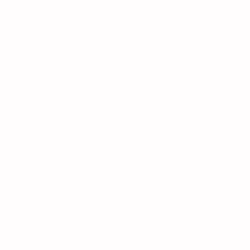

In [11]:
# Plotting

fname = "field.gif"
fps = 1
duration = 1.0 / fps

norm = Normalize(vmin=-1, vmax=1, clip=True)
cmap = plt.get_cmap("seismic")
with imageio.get_writer(fname, mode='I', duration=duration) as writer:
    for arr in snapshots:
        rgba = cmap(norm(arr))            # (H, W, 4) floats 0..1
        rgb = (rgba[..., :3] * 255).astype('uint8')  # converte para uint8
        writer.append_data(rgb)

Image(filename=fname)